In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Freeman & Fried (2011), Fig. 2

In [2]:
# Data extracted from Fig. 2 of Freeman & Fried (2011)
freeman = dict()

freeman['norm_resp'] = dict()
freeman['norm_resp']['2'] = np.array([1.00000, 1.00000, 2.02247, 0.71475,
                                        2.98876, 0.68852, 3.95506, 0.65902,
                                        4.94382, 0.63934, 5.91011, 0.62623,
                                        6.89888, 0.62951, 7.88764, 0.62951,
                                        8.87640, 0.62623, 9.86517, 0.61311]).reshape((-1, 2))
freeman['norm_resp']['4'] = np.array([1.00000, 1.00000, 1.97753, 0.69836,
                                        2.98876, 0.60656, 3.95506, 0.58361,
                                        4.92135, 0.54098, 5.91011, 0.52787,
                                        6.89888, 0.53443, 7.93258, 0.52131,
                                        8.89888, 0.51148, 9.86517, 0.51148]).reshape((-1, 2))
freeman['norm_resp']['8'] = np.array([1.00000, 1.00000, 1.97753, 0.59672,
                                        3.03371, 0.52787, 3.97753, 0.47869,
                                        4.94382, 0.43607, 5.93258, 0.43279,
                                        6.92135, 0.40984, 7.88764, 0.37377,
                                        8.87640, 0.38689, 9.86517, 0.36721]).reshape((-1, 2))
freeman['norm_resp']['16'] = np.array([1.03371, 0.98361, 2.00000, 0.66557,
                                         2.98876, 0.48525, 3.97753, 0.42295,
                                         4.96629, 0.37049, 5.93258, 0.32787,
                                         6.92135, 0.31475, 7.93258, 0.29508,
                                         8.87640, 0.28197, 9.91011, 0.28197]).reshape((-1, 2))

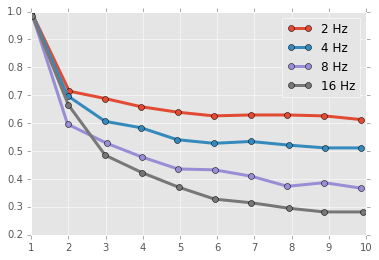

In [3]:
for cond in ['2', '4', '8', '16']:
    plt.plot(freeman['norm_resp'][cond][:, 0], freeman['norm_resp'][cond][:, 1], 'o-',
             linewidth=3, label=cond + ' Hz')
plt.legend()

# Functions
-----------------

Following are all utily funcions used in this script.

In [4]:
class GanglionCellResponse(ec2b.TemporalModel):
    def __init__(self, tsample, tau_inl=18.0 / 1000, delay_inl=40.0 / 1000,
                 lweight=0.636):
        super(GanglionCellResponse, self).__init__(tsample, tau_inl=tau_inl,
                                                   delay_inl=delay_inl,
                                                   lweight=lweight)
        
    def stationary_nonlinearity(self, resp):
        return resp
    
    def slow_response(self, resp):
        return resp

In [5]:
implant = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

r_sampling = 100
axon_lambda = 2 
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                     xlo=implant[0].x_center, xhi=implant[0].x_center,
                     ylo=implant[0].y_center, yhi=implant[0].y_center)

In [6]:
pdur = 1.0 / 1000
tsample = 0.005 / 1000
amp = 20

In [7]:
delay_inl = 40.0 / 1000
tau_inl = 1.0 / 1000
lweight = 0.636
ecs_scale = 1.0
tm = GanglionCellResponse(tsample=tsample, delay_inl=delay_inl,
                          tau_inl=tau_inl, lweight=lweight)

In [8]:
[10.0 / f for f in [2, 4, 8, 16]]

[5.0, 2.5, 1.25, 0.625]

In [9]:
model = dict()
model['resp'] = dict()
for freq in [2, 4, 8, 16]:
    freqstr = str(freq)
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=10.0 / freq,
                                  pulse_dur=pdur, interphase_dur=0, pulsetype='cathodicfirst', delay=20.0 / 1000)
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                             ecs_scale=ecs_scale, engine='joblib', rsample=1)
    model['resp'][freqstr] = np.squeeze(mov.data)

2017-02-03 10:12:08,120 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 10:12:08,477 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 10:12:08,744 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 10:12:08,883 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


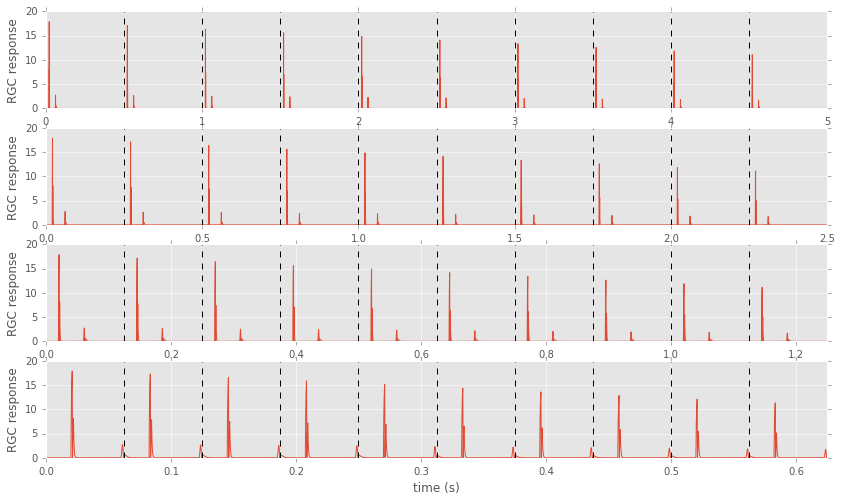

In [10]:
plt.figure(figsize=(14, 8))
for i, freq in enumerate([2, 4, 8, 16]):
    plt.subplot(4, 1, i + 1)
    
    freqstr = str(freq)
    t = np.arange(model['resp'][freqstr].size) * tsample
    plt.plot(t, model['resp'][freqstr])
    freqsize = int(model['resp'][freqstr].size / 10.0)
    for f in range(10):
        plt.plot([f*freqsize * tsample, f*freqsize * tsample], [0, 20], 'k--', linewidth=1)
    plt.xlim(0, t.max())
    plt.ylim(0, 20)
    plt.xlabel('time (s)')
    plt.ylabel('RGC response')

In [11]:
model['norm_resp'] = dict()
for freqstr in model['resp']:
    resp = model['resp'][freqstr]
    freq_size = int(resp.size / 10.0)
    
    peaks = []
    for f in range(10):
        slc = resp[f*freq_size: (f + 1) * freq_size]
        peaks.append(slc.max())
        

    model['norm_resp'][freqstr] = peaks / peaks[0]

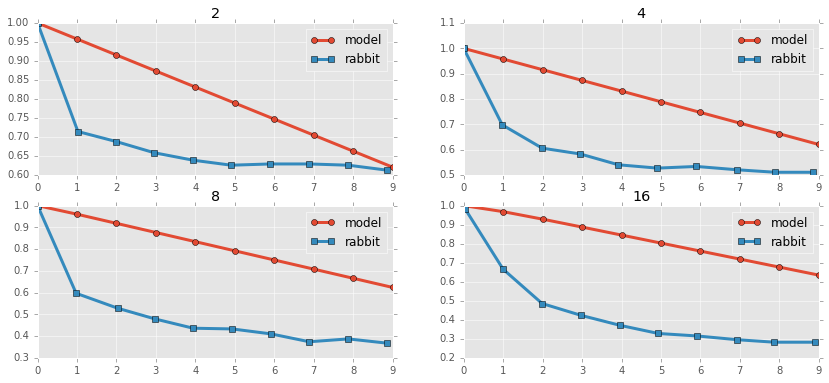

In [12]:
num_cols = np.floor(np.sqrt(len(model['resp'])))
num_rows = np.ceil(len(model['resp']) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate([2, 4, 8, 16]):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(model['norm_resp'][freqstr], 'o-',
             linewidth=3, label='model')
    plt.plot(freeman['norm_resp'][freqstr][:, 0] - 1,
             freeman['norm_resp'][freqstr][:, 1], 's-',
             linewidth=3, label='rabbit')
    plt.title(freqstr)
    plt.legend(loc='best')